# Introduction to Jupyter Notebooks
## JupyterLab 🧪

**For an overview of the JupyterLab interface**, see the **JupyterLab Welcome Tour** on this page, by going to `Help -> Welcome Tour` and following the prompts.

> **See Also**: For a more in-depth tour of JupyterLab with a full environment that runs in the cloud, see [the JupyterLab introduction on Binder](https://mybinder.org/v2/gh/jupyterlab/jupyterlab-demo/HEAD?urlpath=lab/tree/demo).


# Importations and environment

In [21]:
%pip install lsfb_dataset
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import os
from lsfb_dataset import Downloader
import cv2
from cv2 import VideoCapture
import mediapipe as mp

# Data Processing
## Download dataset
- Quote lsfb-dataset
- describing data

In [23]:
downloader = Downloader(
    dataset='isol',
    destination="../Database/Dataset",
    splits=['train','test'],
    signers=list(range(8)),
    include_cleaned_poses=True,
    include_raw_poses=False,
    include_videos=True,
    landmarks=['pose', 'left_hand', 'right_hand'],
    skip_existing_files=True,
)
downloader.download()


Metadata:   0%|          | 0/13 [00:00<?, ?files/s]

Poses for 19926 instances [pose, left_hand, right_hand]:   0%|          | 0/59778 [00:00<?, ?files/s]

Videos for 19926 instances:   0%|          | 0/19926 [00:00<?, ?files/s]

In [24]:
# from lsfb_dataset import LSFBIsolConfig, LSFBIsolLandmarks

# dataset = LSFBIsolLandmarks(LSFBIsolConfig(
#     root="../Database/Dataset",
#     landmarks=('pose', 'left_hand', 'right_hand'),
#     sequence_max_length=50,
#     use_3d=True,
#     n_labels=10,
#     target='sign_index',
#     show_progress=True
# ))
# features, target = dataset[0]

## Select data
The selection of a video is based on the following criteria : 
 - it has more than 10 frames and less than 50 frames
 - it represents one of the ten most represented signs of the database

In [2]:
df_index = pd.read_csv('../Database/Dataset/metadata/sign_occurrences.csv')
signs = [df_index.loc[i, "sign"] for i in range(3)]
print("For the rest of the project, we will use the following words")
print(signs)

For the rest of the project, we will use the following words
['AUSSI', 'LS', 'OUI']


How many values for each word ?

In [3]:
df_instances = pd.read_csv('../Database/Dataset/instances.csv')
videos_directory = "../Database/Dataset/videos/"

def Paths_Videos_Signing(word):
    videos = []
    for i in range(len(df_instances)):
        path = videos_directory + df_instances.loc[i,"id"] + ".mp4"
        if df_instances.loc[i, "sign"]==word and os.path.exists(path):
            videos.append(path)
    return videos

for sign in signs:
    print(f"{sign} : {len(Paths_Videos_Signing(sign))}")

AUSSI : 371
LS : 342
OUI : 314


Selection of data

In [27]:
def Paths_Selected_Videos(word):
    videos = Paths_Videos_Signing(word)
    selected_videos = []
    for video in videos:
        cap = cv2.VideoCapture(video)
        length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if length>10 and length<50:
            selected_videos.append(video)
    return selected_videos

for sign in signs:
    print(f"Number of videos signing '{sign}' before selection : {len(Paths_Videos_Signing(sign))}")
    print(f"Number of videos signing '{sign}' after selection : {len(Paths_Selected_Videos(sign))}")

Number of videos signing 'AUSSI' before selection : 371
Number of videos signing 'AUSSI' after selection : 297
Number of videos signing 'LS' before selection : 342
Number of videos signing 'LS' after selection : 297
Number of videos signing 'OUI' before selection : 314
Number of videos signing 'OUI' after selection : 265


## Data processing

### Vectorization of data
#### Coordinates extraction with MediaPipe

> **Warning**: We are working on a particular video signing a particular sign in order to create usseful functions. If you want to see the final code vectorizing data and saving them under csv please refer too Generalisation. 


In [28]:
points = [0,4,8,12,16,20]
video = Paths_Selected_Videos("LS")[0]

- Modelisation
- Documentation MediaPipe
- Image of points on hand from MediaPipe

In [29]:
# Téléchargement du modèle détecteur de mains
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.8)

- First, 1 line for 1 point (frames in columns) :

> **Warning**: We put 0 in values lacking because we want to distinguish them from NaN (auto-completion from pandas dataframes)

In [30]:
def Vectorize(video_path, points):
    capture = VideoCapture(video_path)

    vect = [ [] for i in range(len(points))]
    while capture.isOpened():
        ret, frame = capture.read()
        if not ret:
            break 
        
        #BGR to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)# MediaPipe works with RGB format

        # Set flag
        image.flags.writeable = False

        #Detections
        results = hands.process(image)
        rang = 0
        for point in points:
            res = results.multi_hand_world_landmarks
            if res == None: # Without hand detection
                vect[rang].append("0")
                vect[rang].append("0")
                vect[rang].append("0")
                vect[rang].append("0")
                vect[rang].append("0")
                vect[rang].append("0")
            else :
                if len(res)>=2: # With a detection of both hands
                    hand = results.multi_hand_world_landmarks[0]
                    vect[rang].append(hand.landmark[point].x)
                    vect[rang].append(hand.landmark[point].y)
                    vect[rang].append(hand.landmark[point].z)
                    hand = results.multi_hand_world_landmarks[1]
                    vect[rang].append(hand.landmark[point].x)
                    vect[rang].append(hand.landmark[point].y)
                    vect[rang].append(hand.landmark[point].z)          
                
                elif len(res)==1: # With a one-hand detection
                    res2 = results.multi_handedness[0]
                    label = res2.classification[0].label
                    hand = results.multi_hand_world_landmarks[0]
                    if label == "Left":
                        vect[rang].append(hand.landmark[point].x)
                        vect[rang].append(hand.landmark[point].y)
                        vect[rang].append(hand.landmark[point].z)
                        vect[rang].append("0")
                        vect[rang].append("0")
                        vect[rang].append("0")
                        
                    elif label == "Right" :
                        vect[rang].append("0")
                        vect[rang].append("0")
                        vect[rang].append("0")
                        vect[rang].append(hand.landmark[point].x)
                        vect[rang].append(hand.landmark[point].y)
                        vect[rang].append(hand.landmark[point].z)
                
            rang +=1
        
    return vect

# vector = Vectorize(video, points)
# for point in points:
#     print(f"P{point} : {vector[points.index(point)]}")

- Conversion to dataframe format

In [31]:
def Create_DataFrame(video, points):
    vect = Vectorize(video, points)
    col = ["Points"]
    
    for i in range(len(vect[0])//6):
        col += [f'xG{i}',f'yG{i}',f'zG{i}',f'xD{i}',f'yD{i}',f'zD{i}']
    
    df = pd.DataFrame(None, columns = col)
    for i in range(len(points)):
        df.loc[len(df.index)] = [f"P{4*i}"] + vect[i]

    return df

Create_DataFrame(video, points)

,Points,xG0,yG0,zG0,xD0,yD0,zD0,xG1,yG1,zG1,...,zG15,xD15,yD15,zD15,xG16,yG16,zG16,xD16,yD16,zD16
0,P0,-0.035230,0.042146,0.073656,0.066154,0.008858,0.059337,-0.025272,0.046615,0.075060,...,0.075538,0.043564,0.014199,0.079540,0.029654,0.055051,0.074103,0.062954,0.018715,0.057508
1,P4,0.006634,-0.054196,0.005010,-0.001107,-0.074753,-0.000785,0.019382,-0.050444,0.009267,...,-0.000306,-0.025795,-0.061216,0.017933,0.062072,-0.047171,-0.012701,-0.015709,-0.005951,0.025426
2,P8,0.034817,0.017221,0.041634,-0.061179,-0.030260,0.020100,0.055951,0.004189,0.023389,...,-0.042504,-0.027040,-0.051357,-0.033080,-0.019221,-0.061134,-0.048849,-0.035414,-0.060699,-0.012632
3,P12,0.029182,0.012646,0.035624,-0.076076,0.001638,0.029415,0.047710,0.012097,0.028550,...,-0.071690,-0.048773,-0.010769,-0.022032,-0.043118,-0.027342,-0.067052,-0.057198,-0.011822,0.005704
4,P16,0.025709,0.027869,0.028479,-0.060427,0.019197,0.024898,0.044877,0.027482,0.027394,...,-0.057073,-0.057068,0.029403,-0.007605,-0.008420,0.039443,-0.038408,-0.059866,0.037741,0.020737
5,P20,0.033297,0.035249,0.004762,-0.041467,0.057452,0.017356,0.041275,0.039010,0.013481,...,-0.034258,-0.040132,0.061078,0.000094,-0.006039,0.052325,-0.017872,-0.038108,0.067305,0.020124


#### Generalisation

- Save data from every video signing a word represented more than 100 times. --> useful for a future spread ?
- In a csv files containing all the videos signing a particular word

In [32]:
def Concatenate_DataFrame(sign, points):
    videos = Paths_Selected_Videos(sign)
    df = pd.DataFrame(None)

    if len(videos)>=100:
        for video in videos:
            df = pd.concat([df,Create_DataFrame(video, points)], ignore_index=True)
    return df
#Concatenate_DataFrame("LS", points)

In [33]:
def SaveInCSV(sign, points):
    df = Concatenate_DataFrame(sign, points)
    df.to_csv(f'../Database/Positions/{sign}.csv', index=False)

In [34]:
# for sign in signs:
#     SaveInCSV(sign,points)

### Data cleaning/preparation

In [35]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [36]:
List_df_signs = [pd.read_csv(f"../Database/Positions/{sign}.csv") for sign in signs]
df_All = pd.concat(List_df_signs)
df_All

,Points,xG0,yG0,zG0,xD0,yD0,zD0,xG1,yG1,zG1,...,zG47,xD47,yD47,zD47,xG48,yG48,zG48,xD48,yD48,zD48
0,P0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015559,0.083049,0.044787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034177,-0.023254,-0.028474,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.004072,-0.096158,-0.025613,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027751,0.022401,-0.015144,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021707,0.047777,-0.010973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585,P4,-0.028997,-0.042513,-0.014408,0.049538,-0.024548,0.038528,-0.019001,-0.030375,-0.018096,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1586,P8,-0.049347,-0.006162,0.026933,0.006294,-0.057649,0.000284,-0.035912,0.003422,0.031925,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1587,P12,-0.057467,0.014506,0.034316,0.021845,-0.047284,-0.020255,-0.045663,0.021027,0.035548,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1588,P16,-0.049903,0.034173,0.034643,0.029424,-0.040727,-0.034952,-0.038721,0.034162,0.029932,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Convert to numpy to concatenate rows

In [37]:
All = np.array(df_All)
final_vector = []
for i in range (len(All)//len(points)):
    final_vector += [np.concatenate([All[point+i*6][1:] for point in range(6)])]
        # final_vector.append(All[num_point+i*6][1:])
print(len(final_vector))

859


- Return to Dataframe

In [38]:
df_All = pd.DataFrame(final_vector)
df_All

,0,1,2,3,4,5,6,7,8,9,...,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015559,0.083049,0.044787,0.006316,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012938,0.082440,0.041306,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060475,0.006571,0.077605,0.012307,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.049384,0.030766,0.071968,-0.016525,0.074820,0.068859,0.049453,0.028812,0.075394,-0.008487,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.049849,0.021614,0.077442,-0.022396,0.072228,0.072210,0.046102,0.027305,0.079739,-0.012087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,0.015995,0.019285,0.051130,0.000000,0.000000,0.000000,0.001821,0.000036,0.074452,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
855,0.033612,-0.014114,0.030079,0.007130,0.091156,-0.008275,0.040506,-0.021593,0.035359,0.023317,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
856,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.056637,-0.014326,0.064942,0.026982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
857,0.000000,0.000000,0.000000,0.034085,0.007794,0.072282,0.000000,0.000000,0.000000,0.061211,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Find targets

In [39]:
df_correspondances = pd.read_csv('../Database/sign_to_index.csv')
targets =[]
for num_sign in range(len(signs)):
    ind = 0
    nb_videos = List_df_signs[num_sign].shape[0]//len(points)
    while ind < df_correspondances.shape[0] and df_correspondances.loc[ind, "sign"]!=signs[num_sign]:
        ind+=1
    targets += [ind]*nb_videos
unique, counts = np.unique(targets, return_counts=True)
dict(zip(unique, counts))

{0: 297, 1: 297, 2: 265}

- Concatenate data (X and y)

In [54]:
X = np.array(df_All)
X_training, X_test, y_training, y_test = train_test_split(X, targets, test_size=0.20)
df_training = pd.DataFrame(X_training)
df_training
df_training.insert(loc=0, column='Target', value=y_training)
df_test = pd.DataFrame(X_test)
df_test.insert(loc=0, column='Target', value=y_test)
df_training

,Target,0,1,2,3,4,5,6,7,8,...,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763
0,1,0.000000,0.000000,0.000000,0.001506,0.030509,0.060779,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013084,0.001663,0.050180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.017013,0.090869,0.007346,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014841,0.084725,0.042627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.019178,0.095155,-0.005185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
683,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.010492,0.026658,0.085955,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
684,0,0.057454,0.015358,0.061259,-0.033047,0.038600,0.082037,0.056987,0.012342,0.059759,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
685,2,-0.014536,0.026682,0.093679,0.002756,0.061454,0.068342,-0.000235,0.013900,0.092820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
df_training.to_csv(f'../DataManipulation/Training.csv', index=False)
df_test.to_csv(f'../DataManipulation/Test.csv', index=False)

#### Data Preparation

On ne garde que les vidéos dont 99% des valeurs enregistrées (pour sa durée) portent de l'information

In [56]:
def Keep_Indicatives(df_data):
    Data = np.array(df_data)
    ind_video = 0 
    for video in Data:
        number_of_zero = np.count_nonzero(video[1:] == 0)
        nbTotal = np.count_nonzero(video[1:] != np.nan)
        if number_of_zero>0.1*nbTotal:
            Data = np.delete(Data, ind_video, axis=0)
        else:
            ind_video +=1
    return Data
df_data = pd.read_csv(f"../DataManipulation/Training.csv")
print(f"Number of videos before selection : {df_training.shape[0]}")
new = Keep_Indicatives(df_training)
print(f"Number of videos after selection : {len(new)}")
unique, counts = np.unique(new[:,0], return_counts=True)
dict(zip(unique, counts))

Number of videos before selection : 687
Number of videos after selection : 421


{0.0: 174, 1.0: 119, 2.0: 128}

In [57]:
df_training = pd.DataFrame(Keep_Indicatives(df_training))
df_test = pd.DataFrame(Keep_Indicatives(df_test))
df_training

,0,1,2,3,4,5,6,7,8,9,...,1755,1756,1757,1758,1759,1760,1761,1762,1763,1764
0,1.0,0.000000,0.000000,0.000000,0.001506,0.030509,0.060779,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013084,0.001663,0.050180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.017013,0.090869,0.007346,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014841,0.084725,0.042627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,-0.044600,0.061478,0.060522,0.000000,0.000000,0.000000,0.040430,0.006669,0.078456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.019178,0.095155,-0.005185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
419,0.0,0.057454,0.015358,0.061259,-0.033047,0.038600,0.082037,0.056987,0.012342,0.059759,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Transformer les NaN en 0

In [58]:
Data_training = SimpleImputer(strategy="constant", missing_values=np.nan, fill_value=0).fit_transform(df_training)
Data_test = SimpleImputer(strategy="constant", missing_values=np.nan, fill_value=0).fit_transform(df_test)

In [59]:
X_training = [Data_training[video][1:] for video in range(len(Data_training))]
y_training = [Data_training[video][0] for video in range(len(Data_training))]
X_test = [Data_test[video][1:] for video in range(len(Data_test))]
y_test = [Data_test[video][0] for video in range(len(Data_test))]

# Support vector machines
## Training

In [80]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

- Learn

In [64]:
SVM_model = svm.SVC(probability=True)
SVM_model.fit(X_training, y_training)

SVC(probability=True)

- Accuracy

In [66]:
y_pred = SVM_model.predict(X_test)
train_acc = SVM_model.score(X_training, y_training)
print(f"Training accuracy: {train_acc:.05f}")
test_acc = np.sum(y_pred == y_test) / len(y_test)
print(f"Test accuracy: {test_acc:.3f}")


Training accuracy: 0.96675
Test accuracy: 0.865


- Cross-validation

In [72]:
cv_acc_training = cross_val_score(SVM_model, X_training, y_training, cv=5, scoring="accuracy")
cv_acc_test = cross_val_score(SVM_model, X_test, y_test, cv=5, scoring="accuracy")
print(f"Cross-validation training accuracy: {cv_acc_training}")
print(f"Cross-validation test accuracy: {cv_acc_test}")

Cross-validation training accuracy: [0.8        0.79761905 0.91666667 0.82142857 0.92857143]
Cross-validation test accuracy: [0.80952381 0.71428571 0.66666667 0.57142857 0.8       ]


In [79]:
print(classification_report(y_training, SVM_model.predict(X_training)))
print(classification_report(y_test, SVM_model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       174
         1.0       0.95      0.97      0.96       119
         2.0       0.98      0.95      0.96       128

    accuracy                           0.97       421
   macro avg       0.97      0.96      0.97       421
weighted avg       0.97      0.97      0.97       421

              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90        40
         1.0       0.87      0.90      0.88        29
         2.0       0.87      0.74      0.80        35

    accuracy                           0.87       104
   macro avg       0.87      0.86      0.86       104
weighted avg       0.87      0.87      0.86       104



Confusion matrix, without normalization
[[38  0  2]
 [ 1 26  2]
 [ 5  4 26]]
Normalized confusion matrix
[[0.95       0.         0.05      ]
 [0.03448276 0.89655172 0.06896552]
 [0.14285714 0.11428571 0.74285714]]


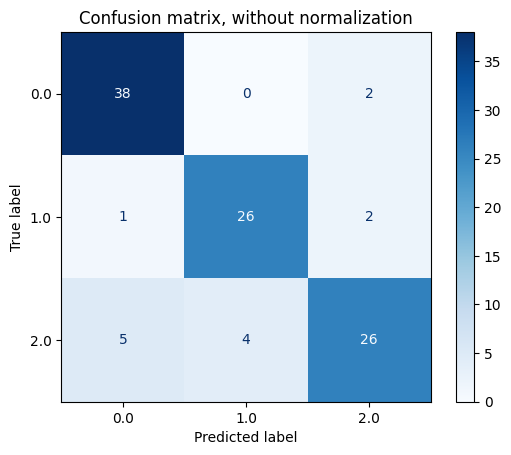

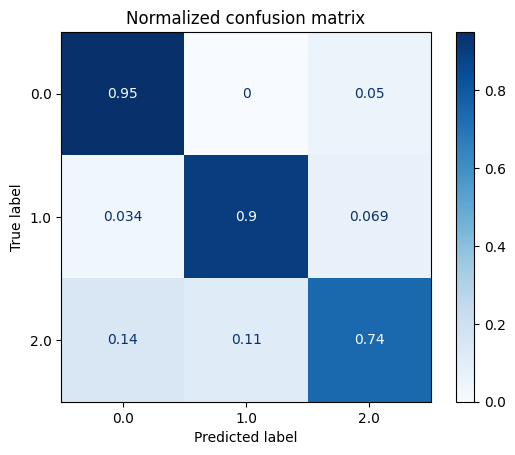

In [81]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        SVM_model,
        X_test,
        y_test,
        #display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()